In [2]:
# Exploratory code to find the best fit of delta height time series in gridded
# ICESat-2 ATL15 and CryoSat-2 SARIn data
#
# This code run continental-scale operations on multiple datasets and
# requires a XX GB server or local memory
#
# Written 2024-3-5 by W. Sauthoff (wsauthoff.github.io)

In [1]:
%pip install openpyxl

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [87]:
# Import libraries
from datetime import datetime
import earthaccess
import geopandas as gpd
import matplotlib.colors as mpl_colors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from pyproj import CRS, Transformer
import rioxarray
from shapely.geometry import Polygon, MultiPolygon
from skimage import measure
import time
import warnings
import xarray as xr

# Magic functions
%matplotlib widget

# Define data directories dependent on home environment
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    SCRIPT_DIR = '/home/jovyan/repos_my/scripts'
    OUTPUT_DIR = '/home/jovyan/1_outlines_candidates/output/'
    
# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326"  # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod()  # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031"  # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True)  # make coord transformer

# Change default font to Arial and increase font size
# plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 14})

# Import datasets

In [3]:
# Find ICESat-2 ATL15 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.003',
    # short_name='ATL15',
    # version='003',
    cloud_hosted=True,
    bounding_box=(180, -90, -180, -60)  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
)

Granules found: 16


In [4]:
# Open data granules as s3 files to stream
files = earthaccess.open(results)

Opening 16 granules, approx size: 5.05 GB


QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [5]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_10km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_20km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_40km_003_01.nc>,
 <File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A

In [6]:
# After viewing files, index the files you wish to open
print(files[15])
print(files[3])
print(files[9])
print(files[11])

<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A1_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A2_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A3_0318_01km_003_01.nc>
<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL15.003/2019.03.29/ATL15_A4_0318_01km_003_01.nc>


In [7]:
# Open each file, which are quadrants in polar stereographic coordinations around the Geographic South Pole
ATL15_A1 = xr.open_dataset(files[15], group='delta_h')
ATL15_A2 = xr.open_dataset(files[3], group='delta_h')
ATL15_A3 = xr.open_dataset(files[9], group='delta_h')
ATL15_A4 = xr.open_dataset(files[11], group='delta_h')

In [8]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h']

# List of xarray datasets
datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Apply the function to each dataset
ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [9]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [10]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [11]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15 = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [12]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [13]:
# Add datasets attributes and set CRS
ATL15.attrs['identifier_product_DOI'] = '10.5067/ATLAS/ATL15.003'
ATL15.attrs['shortName'] = 'ATL15'
ATL15.rio.write_crs("epsg:3031", inplace=True)

<xarray.Dataset>
Dimensions:              (time: 19, x: 5461, y: 4461)
Coordinates:
  * time                 (time) datetime64[ns] 2018-10-01T22:30:00 ... 2023-0...
  * x                    (x) float64 -2.67e+06 -2.669e+06 ... 2.789e+06 2.79e+06
  * y                    (y) float64 -2.19e+06 -2.189e+06 ... 2.269e+06 2.27e+06
    Polar_Stereographic  int64 0
Data variables:
    delta_h              (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    description:             delta_h group includes variables describing heig...
    identifier_product_DOI:  10.5067/ATLAS/ATL15.003
    shortName:               ATL15

In [14]:
# MEaSUREs Antarctic Boundaries for IPY 2007-2009 from Satellite Radar V002 (Mouginot and others, 2017)
# https://doi.org/10.5067/AXE4121732AD
# https://nsidc.org/sites/default/files/nsidc-0709-v002-userguide.pdf
IMBIE_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_IMBIE_Antarctica_v02.shp')
refined_basins = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/Basins_Antarctica_v02.shp')
ice_boundaries = gpd.read_file(DATA_DIR + '/boundaries/measures_Antarctic_boundaries/IceBoundaries_Antarctica_v02.shp')
grounded_ice_boundaries = ice_boundaries[ice_boundaries["TYPE"]=='GR']

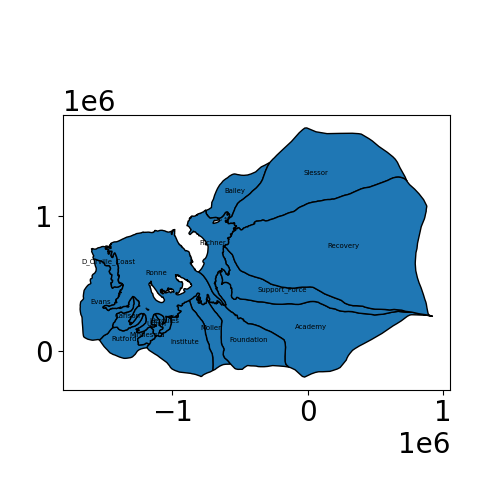

In [16]:
# Plot Filchner-Ronne Ice Shelf polygons
fig, ax = plt.subplots(figsize=(5, 5))
names_to_filter = ['Filchner', 'Ronne', 'Ronne_Ice']
ice_boundaries[ice_boundaries['Asso_Shelf'].isin(names_to_filter) | ice_boundaries['NAME'].isin(names_to_filter)].plot(ax=ax, edgecolor='k')

# Adding labels from the 'NAME' column
for idx, row in ice_boundaries[ice_boundaries['Asso_Shelf'].isin(names_to_filter) | ice_boundaries['NAME'].isin(names_to_filter)].iterrows():
    plt.annotate(text=row['NAME'], xy=(row['geometry'].centroid.x, 
                                       row['geometry'].centroid.y),
                 horizontalalignment='center', color='k', size=5)

plt.show()

<Axes: >

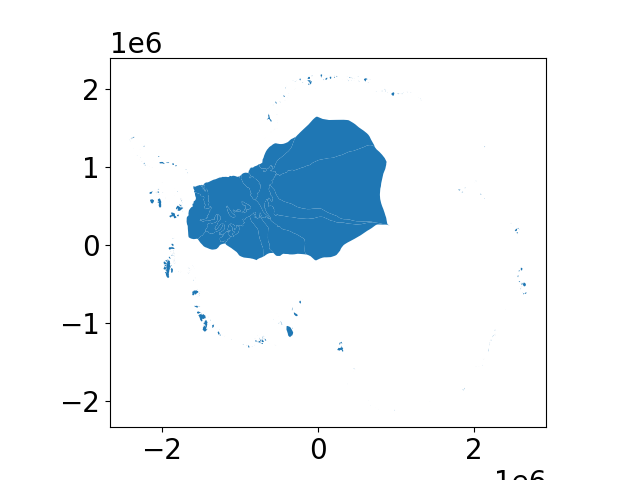

In [17]:
ice_boundaries[ice_boundaries['Asso_Shelf'].isin(names_to_filter) | ice_boundaries['NAME'].isin(names_to_filter) | (ice_boundaries['TYPE'] == 'IS')].plot()

In [18]:
# Create geodataframe of FRIS, associated grounded ice and islands
names_to_filter = ['Filchner', 'Ronne']
FRIS_gdf = ice_boundaries[ice_boundaries['NAME'].isin(names_to_filter) | (ice_boundaries['TYPE'] == 'IS')]

# Collapse all Polygon geometries into a single MultiPolygon object
multi_polygon = FRIS_gdf.geometry.unary_union

# # If you want to create a new GeoDataFrame with this single MultiPolygon
# multi_polygon_gdf = gpd.GeoDataFrame([multi_polygon], columns=['geometry'], geometry='geometry')

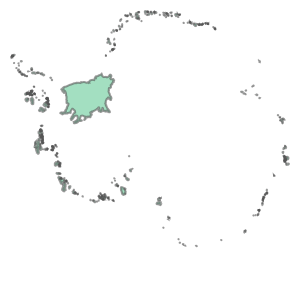

In [19]:
multi_polygon

In [20]:
# Check if the geometry is indeed a MultiPolygon
if isinstance(multi_polygon, MultiPolygon):
    # Use the geoms attribute to access the individual Polygons
    polygons = [polygon for polygon in multi_polygon.geoms]
    
    # Calculate the area of each polygon
    areas = np.array([polygon.area for polygon in polygons])
    
    # Find the index of the polygon with the largest area
    largest_polygon_index = np.argmax(areas)
    
    # Extract the largest polygon
    FRIS = polygons[largest_polygon_index]
else:
    print("The provided geometry is not a MultiPolygon.")

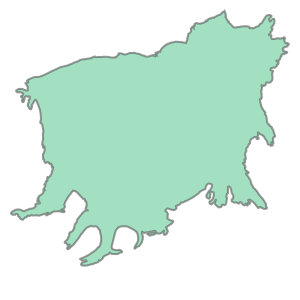

In [21]:
FRIS

In [22]:
# Create geodataframe of FRIS, associated grounded ice and islands
names_to_filter = ['Filchner', 'Ronne', 'Ronne_Ice']
gdf = ice_boundaries[ice_boundaries['Asso_Shelf'].isin(names_to_filter) | ice_boundaries['NAME'].isin(names_to_filter) | (ice_boundaries['TYPE'] == 'IS')]

# Collapse all Polygon geometries into a single MultiPolygon object
multi_polygon = gdf.geometry.unary_union

# # If you want to create a new GeoDataFrame with this single MultiPolygon
# multi_polygon_gdf = gpd.GeoDataFrame([multi_polygon], columns=['geometry'], geometry='geometry')

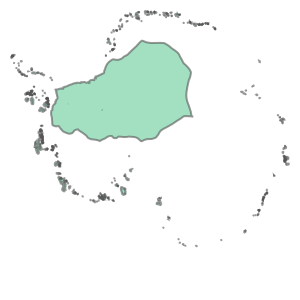

In [23]:
multi_polygon

In [24]:
# Check if the geometry is indeed a MultiPolygon
if isinstance(multi_polygon, MultiPolygon):
    # Use the geoms attribute to access the individual Polygons
    polygons = [polygon for polygon in multi_polygon.geoms]
    
    # Calculate the area of each polygon
    areas = np.array([polygon.area for polygon in polygons])
    
    # Find the index of the polygon with the largest area
    largest_polygon_index = np.argmax(areas)
    
    # Extract the largest polygon
    FRIS_and_catchments = polygons[largest_polygon_index]
else:
    print("The provided geometry is not a MultiPolygon.")

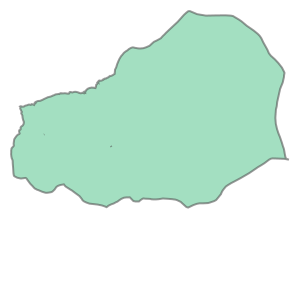

In [25]:
FRIS_and_catchments

In [26]:
# Clip ATL15 to FRIS and associated grounded ice
ATL15_FRIS_clipped = ATL15.rio.clip([FRIS], ATL15.rio.crs)
# ATL15_FRIS_and_catchments_clipped = ATL15.rio.clip([FRIS_and_catchments], ATL15.rio.crs)

# Define functions

In [36]:
def pixel_timeseries_analysis(dataset_variable, func2apply):
    # Start the timer
    start_time = time.time()
  
    # Stack x and y into a single dimension
    stacked = dataset_variable.stack(pixels = ['y', 'x'])

    # Apply linear_trend func across time dimension
    timeseries_stat = stacked.groupby('pixels').apply(func2apply)

    # Unstacking back to original
    timeseries_stat = timeseries_stat.unstack('pixels')

    return timeseries_stat

    # End the time, calculate, and print the duration
    end_time = time.time()
    duration = end_time - start_time
    print(f"The cell ran in {np.round(duration,1)/60} mins.")

In [37]:
def linear_trend(x):
    '''
    Function to compute a linear trend of a timeseries
    '''
    pf = np.polyfit(mdates.date2num(x.time), x, 1)

    return xr.DataArray(pf[0])

In [107]:
def plot_timeseries_stat(timeseries_stat_da, timeseries_stat_str, percentile, diverging=False):
    # Close old plots
    plt.close()
    
    # Visualize time series statistic
    fig, ax = plt.subplots(figsize=(10,7))
           
    x_min = timeseries_stat_da.x.min()
    x_max = timeseries_stat_da.x.max()
    y_min = timeseries_stat_da.y.min()
    y_max = timeseries_stat_da.y.max()

    if diverging == True:
        norm = mpl_colors.TwoSlopeNorm(vmin=np.nanpercentile(timeseries_stat_da, 100-percentile),
                                       vcenter=0,
                                       vmax=np.nanpercentile(timeseries_stat_da, percentile))
        cmap = 'RdBu'
        extend = 'both'
    else:
        norm = None
        cmap = 'Blues'
        extend = 'max'

    clb_full_label = f'{timeseries_stat_str}, {percentile}th percentile cmap max'

    m = ax.imshow(timeseries_stat_da, 
                  extent=[x_min, x_max, y_min, y_max],
                  cmap=cmap, norm=norm, origin='lower')

    # Set axes limits
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Change polar stereographic m to km for cleaner-looking axes labels
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    # ax.axis('off')

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = fig.colorbar(m, cax=cax, extend=extend)
    cbar.set_label(clb_full_label)

    # Label axes and title
    ax.set_xlabel('x [km]', size=15)
    ax.set_ylabel('y [km]', size=15)
    ax.set_title('{} during {} to {}; \n{}th percentile cmap max'.format(timeseries_stat_str, str(ATL15.time[0].values.astype('datetime64[D]')), str(ATL15.time[-1].values.astype('datetime64[D]')), percentile), pad=7.5, fontsize=17.5)

    # Save and close fig
    # plt.savefig('/home/jovyan/1_outlines_candidates/output/ATL15_time_series_analysis/{}/ATL15_{}_{}thpercentile.png'.format(str(timeseries_stat_str), str(timeseries_stat_str), percentile))
    # plt.close()
    plt.tight_layout()
    plt.show()

In [45]:
def time_series_stat_anomalies(ROI, timeseries_stat_da, timeseries_stat_str, percentile, clb_label): 
    '''
    
    '''
    
    # Find x, y min, max
    x_min, x_max = (timeseries_stat_da.x.min().values, timeseries_stat_da.x.max().values)
    y_min, y_max = (timeseries_stat_da.y.min().values, timeseries_stat_da.y.max().values)

    x_conv = (x_max-x_min)/len(timeseries_stat_da.x)
    y_conv = (y_max-y_min)/len(timeseries_stat_da.y)

    # Create contours around min/max grand cumulative sums above a threshold
    # contours_pos = measure.find_contours(np.flip(np.rot90(timeseries_stat_da.values, 1), 0), np.nanpercentile(timeseries_stat_da, percentile))
    contours_pos = measure.find_contours(timeseries_stat_da.values, np.nanpercentile(timeseries_stat_da, percentile))

    # Create empty list to store polygons, areas, perimeters and dates
    polys = []
    areas = []
    perims = []
    percentiles = []

    # Visualize the times series stat 
    fig, ax = plt.subplots(figsize=(10,10))
    img = ax.imshow(timeseries_stat_da, 
        extent=[x_min, x_max, y_min, y_max], 
        cmap='Purples', vmax=np.nanpercentile(timeseries_stat_da, percentile),
        origin='lower')

    # Plot the contours
    for i in range(len(contours_pos)):
        x = x_min+contours_pos[i][:,1]*x_conv
        y = y_min+contours_pos[i][:,0]*y_conv
        ax.plot(x, y, color='magenta', linestyle='solid', 
                linewidth=1, label=percentile)
        
        # Make polygons from evolving outlines and store to list
        if len(contours_pos[i][:,1]) > 2: 
            poly = Polygon(list(zip(x, y))) 
            # polys += [poly]
            polys.append(poly)

            # Calc polygon area and perimeter and store to lists
            lon, lat = XY_TO_LL.transform(x,y)
            poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
            poly_perim = abs(GEOD.polygon_area_perimeter(lon, lat)[1])
            areas += [poly_area]
            perims += [poly_perim]
            percentiles += [percentile]

    # Overlay published active lake outlines and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1)

    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    x_min, x_max = (timeseries_stat_da['x'].min().values-10e3, timeseries_stat_da['x'].max().values+10e3)
    y_min, y_max = (timeseries_stat_da['y'].min().values-10e3, timeseries_stat_da['y'].max().values+10e3)
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.axis('off')

    # Add colorbar and title
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(img, cax=cax, extend='max').set_label('{}'.format(clb_label+', {}th percentile').format(percentile), size=15)
    # ax.set_title('{} with ≥{}th percentile contours'.format(timeseries_stat_str, percentile), size=15)
    
    # Save and close fig
    # plt.savefig(OUTPUT_DIR + 
    #     'ATL15_time_series_analysis/time_series_stat_anomalies/{}/{}_{}_{}thpercentile.png'
    #     .format(timeseries_stat_str, ROI, timeseries_stat_str, percentile), dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()

#     # Store polygons in geopandas geodataframe for further analysis
#     data = {'geometry': polys, 'area (m^2)': areas, 'perim (m)': perims, 'percentile': percentiles}
#     gdf = gpd.GeoDataFrame(data, crs="EPSG:3031")
#     gdf['centroid'] = gdf['geometry'].centroid

#     return gdf

# # Example usage
# gdf = time_series_stat_anomalies(ATL15_dhdt_std, 'ATL15_dhdt_std', 100)

In [46]:
def plot_time_series_stat_anomaly_gdf(ROI, time_series_stat_str, percentile, gdf):
    '''
    
    '''
    # Find x, y min, max
    x_min, x_max = (min(gdf.bounds.minx), max(gdf.bounds.maxx))
    y_min, y_max = (min(gdf.bounds.miny), max(gdf.bounds.maxy))
    
    # Visualize the max grand cumulative sums 
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Plot the outlines
    gdf.boundary.plot(ax=ax, color='magenta', linestyle='solid', 
        linewidth=1, label='lake candidates')
    
    # Overlay published active lake outlines for visual comparison and grounding line
    Smith2009_outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    SiegfriedFricker2018_SF18outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Sauthoff2023_S23outlines.boundary.plot(ax=ax, edgecolor='k', linestyle='solid', linewidth=1)
    Scripps_landice.boundary.plot(ax=ax, edgecolor='blue', linewidth=1, label='grounding line')
    
    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax.yaxis.set_major_formatter(ticks_y)
    
    # Label axes set limits
    ax.set_xlabel('x [km]', size=25)
    ax.set_ylabel('y [km]', size=25)
    ax.set(xlim=(x_min-30e3, x_max+30e3), ylim=(y_min-30e3, y_max+30e3))

    # Add legend and title
    ax.legend()
    ax.set_title('contours of >{}th percentile {}'.format(percentile, time_series_stat_str), size=15)
    
    # Save and close fig
    # plt.savefig(OUTPUT_DIR + 
    #     'ATL15_time_series_analysis/plot_time_series_stat_anomaly_gdf/{}/{}_{}_{}th_percentile.png'.format(time_series_stat_str, ROI, time_series_stat_str, percentile),
    #      dpi=300, bbox_inches='tight')
    # plt.close()
    plt.show()

# Analysis

In [47]:
# Matt's idea of finding the dh/dt by fitting a line to the dh/dt each quarterly cycle 
# to find areas that are anomalous in their dh/dt best fit line or perhaps have a greater std
# https://groups.google.com/g/xarray/c/Q_hfW3Yj9oQ?pli=1

In [50]:
dataset = ATL15_FRIS_clipped

In [51]:
data_stacked = dataset.delta_h.stack(pixels = ('y', 'x'))

In [91]:
# Apply various time series stats across time dimension directly as a method of of 
# data_stacked xarray data array
ATL15_dhdt_mean = data_stacked.mean(dim='time')
ATL15_dhdt_median = data_stacked.median(dim='time')
ATL15_dhdt_std = data_stacked.std(dim='time', ddof=1)  # The ddof=1 argument is for calculating the sample standard deviation. Omit it for the population standard deviation.
ATL15_dhdt_sum = data_stacked.sum(dim='time')
ATL15_dhdt_min = data_stacked.min(dim='time')
ATL15_dhdt_max = data_stacked.max(dim='time')
ATL15_dhdt_range = ATL15_dhdt_max - ATL15_dhdt_min

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [92]:
# # Unstacking back to original
ATL15_dhdt_mean = ATL15_dhdt_mean.unstack('pixels')
ATL15_dhdt_median = ATL15_dhdt_median.unstack('pixels')
ATL15_dhdt_std = ATL15_dhdt_std.unstack('pixels')
ATL15_dhdt_sum = ATL15_dhdt_sum.unstack('pixels')
ATL15_dhdt_min = ATL15_dhdt_min.unstack('pixels')
ATL15_dhdt_max = ATL15_dhdt_max.unstack('pixels')
ATL15_dhdt_range = ATL15_dhdt_range.unstack('pixels')

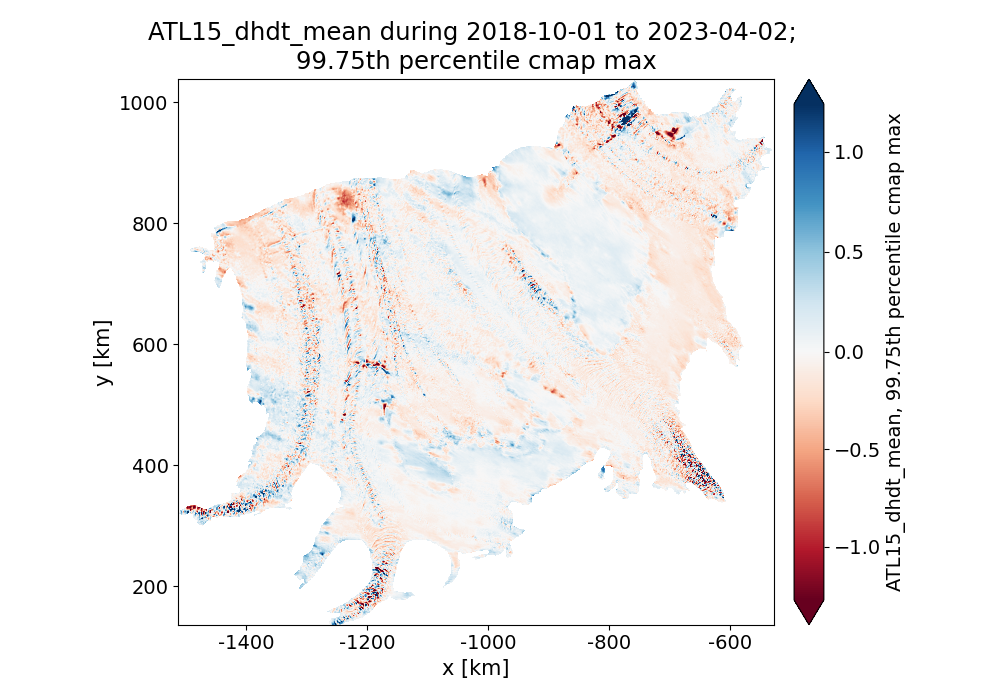

In [116]:
plot_timeseries_stat(ATL15_dhdt_mean, 'ATL15_dhdt_mean', 99.75, diverging=True)

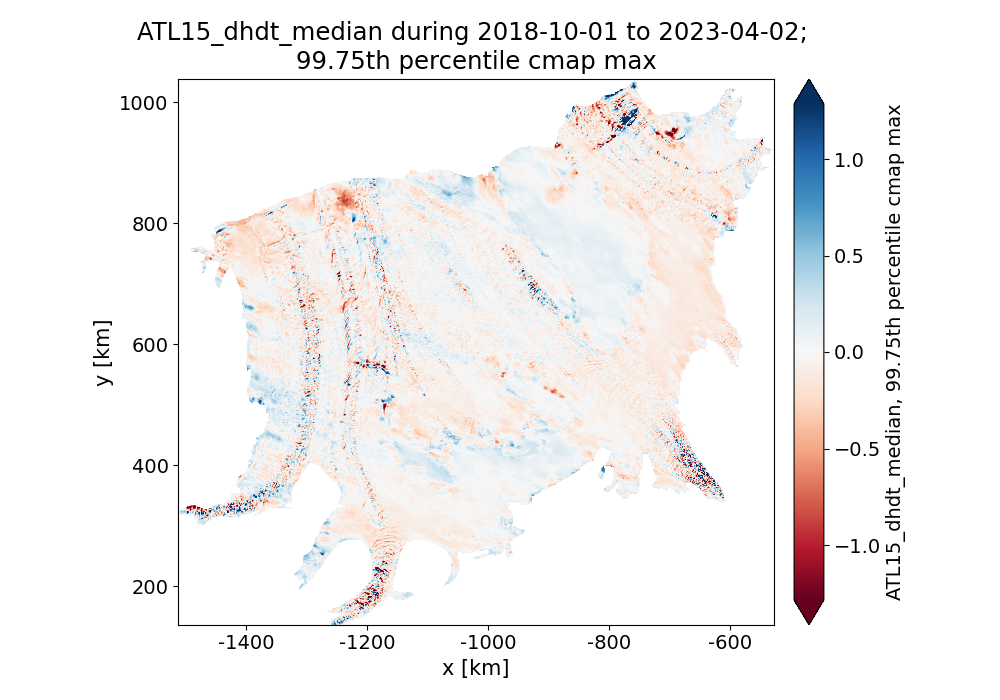

In [117]:
plot_timeseries_stat(ATL15_dhdt_median, 'ATL15_dhdt_median', 99.75, diverging=True)

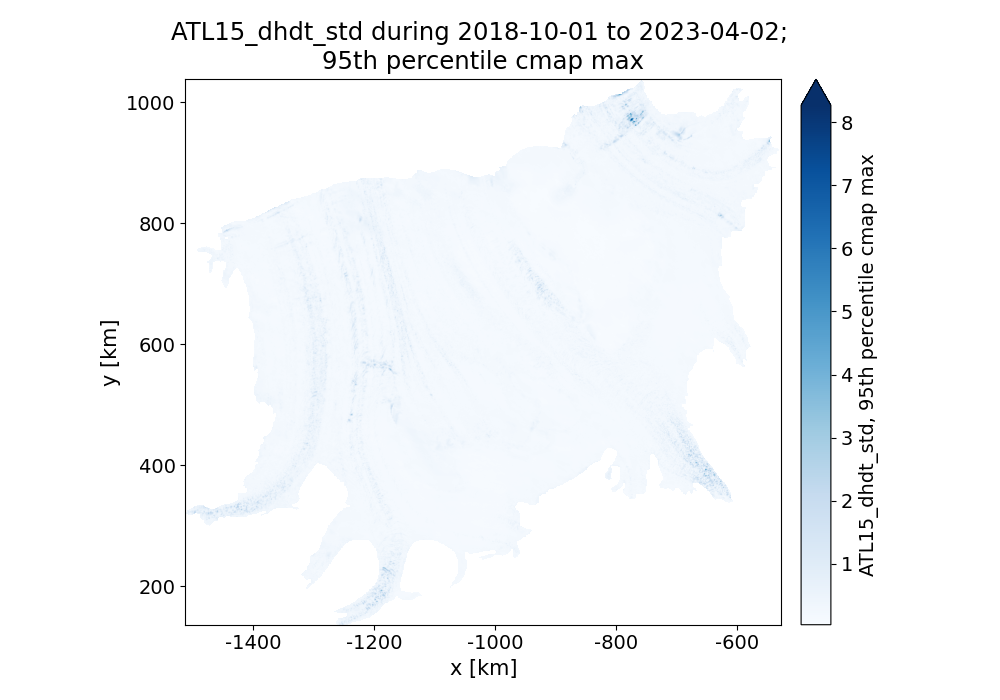

In [118]:
plot_timeseries_stat(ATL15_dhdt_std, 'ATL15_dhdt_std', 95, diverging=False)

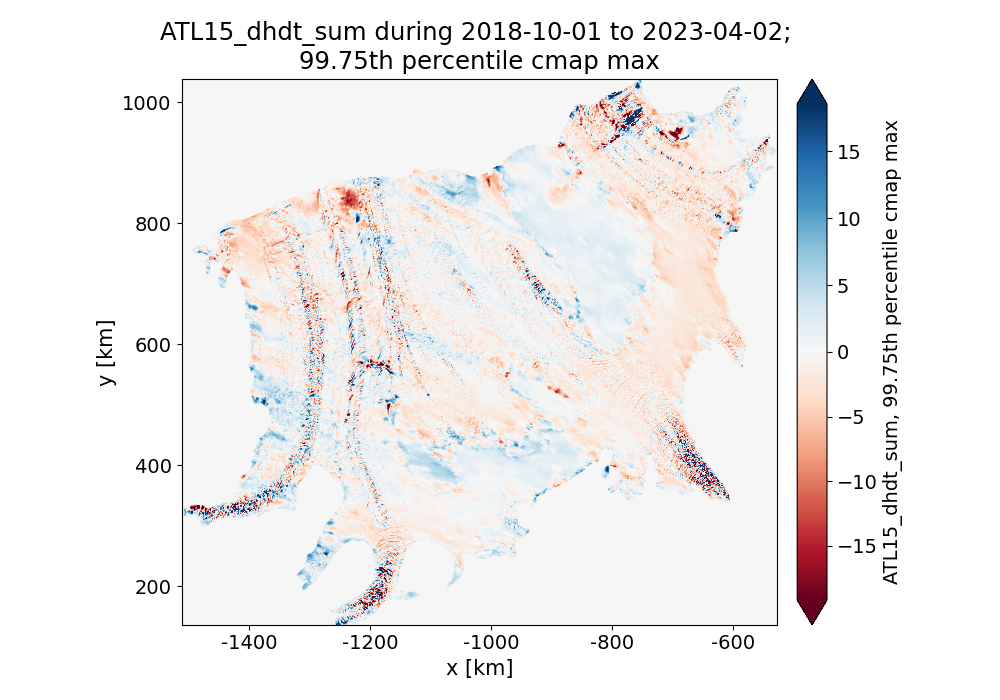

In [119]:
plot_timeseries_stat(ATL15_dhdt_sum, 'ATL15_dhdt_sum', 99.75, diverging=True)

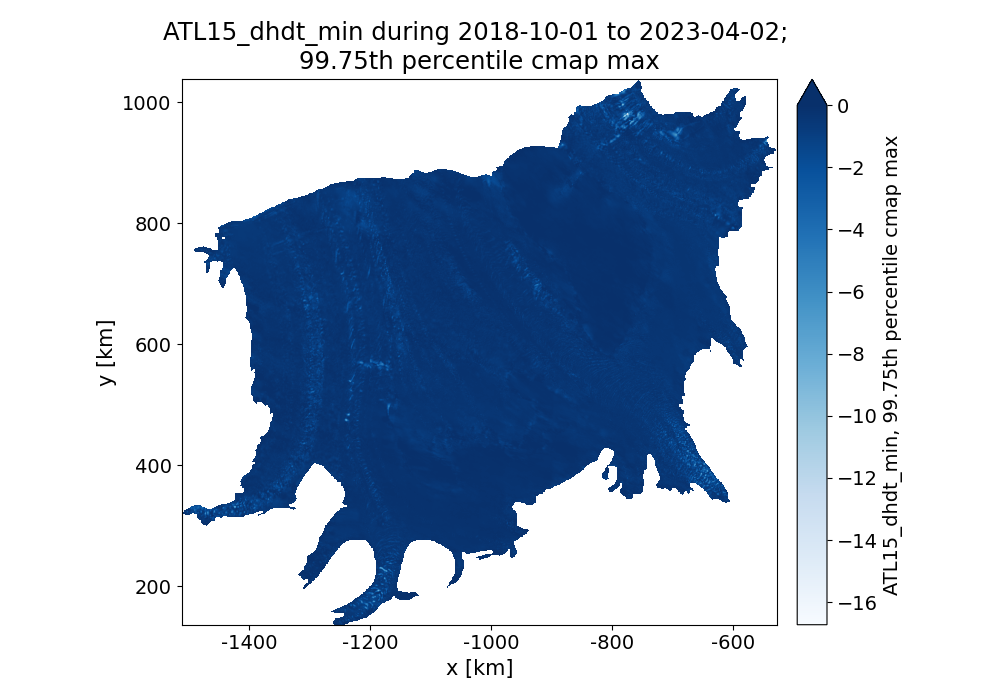

In [120]:
plot_timeseries_stat(ATL15_dhdt_min, 'ATL15_dhdt_min', 99.75, diverging=False)

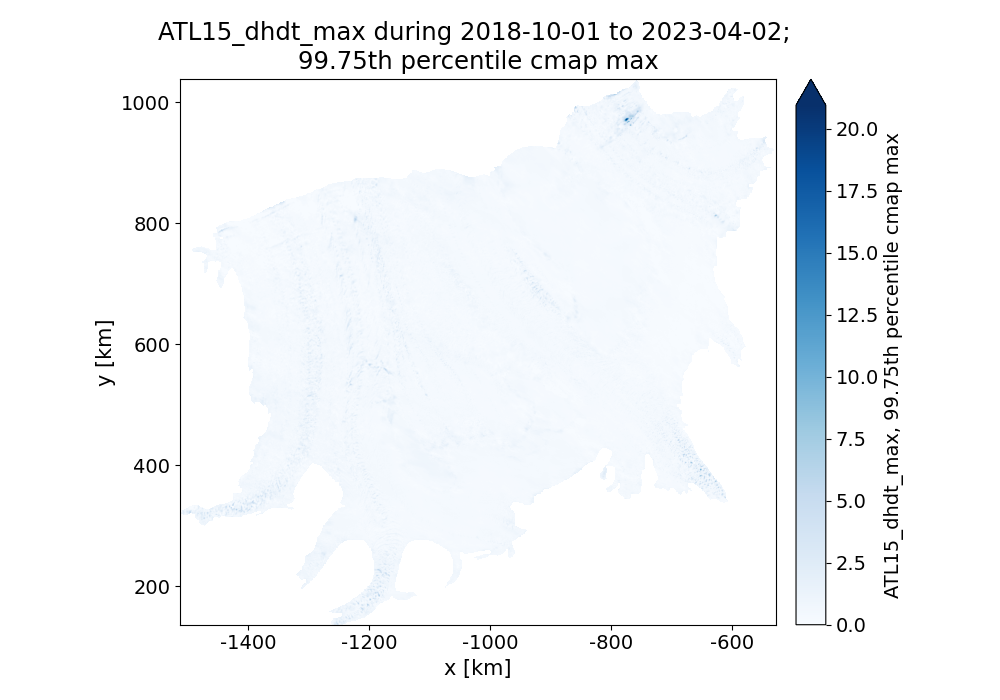

In [121]:
plot_timeseries_stat(ATL15_dhdt_max, 'ATL15_dhdt_max', 99.75, diverging=False)

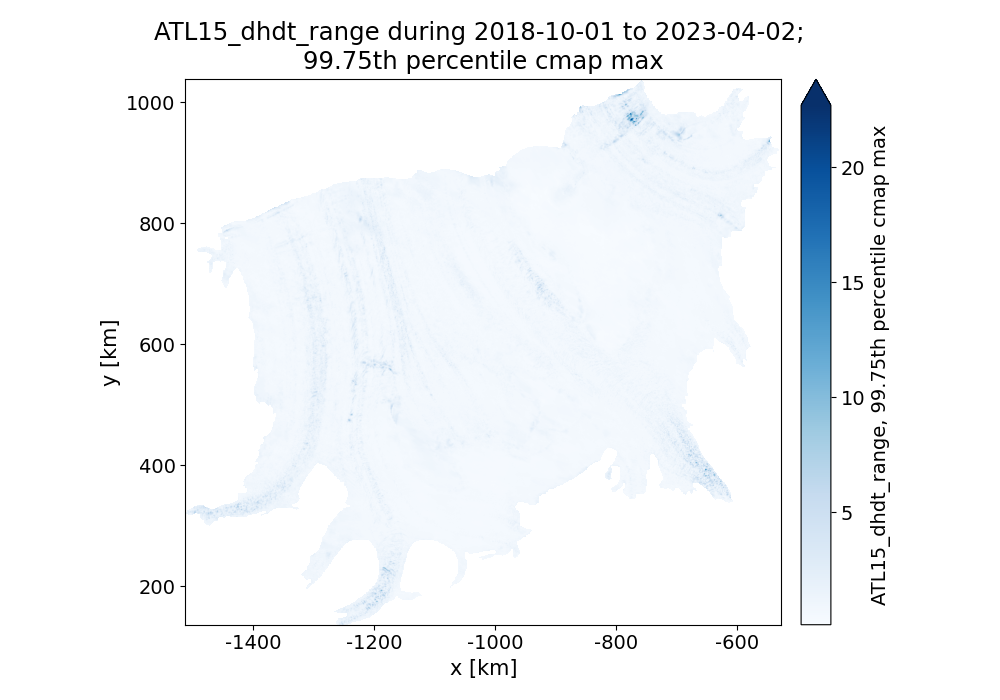

In [122]:
plot_timeseries_stat(ATL15_dhdt_range, 'ATL15_dhdt_range', 99.75, diverging=False)

In [123]:
# plot_timeseries_stat(ATL15_dhdt_std, 'ATL15_dhdt_std', 'Quarterly dh/dt standard deviation', 'dh/dt standard deviation [m/quarter]', incl_lakes=False)
# plot_timeseries_stat(ATL15_dhdt_std, 'ATL15_dhdt_std', 92.5, 'Quarterly dh/dt standard deviation', 'dh/dt standard deviation [m/quarter]', incl_lakes=False)
# plot_timeseries_stat(ATL15_dhdt_std, 'ATL15_dhdt_std', 95, 'Quarterly dh/dt standard deviation', 'dh/dt standard deviation [m/quarter]', incl_lakes=True)

In [124]:
# Run dhdt best fit, which has no .method off xarray dataarray, so must use function (takes a while to run)

In [ ]:
ATL15_dhdt_bestfit = pixel_timeseries_analysis(ATL15_FRIS_clipped['delta_h'], linear_trend)

In [ ]:
plot_timeseries_stat(ATL15_dhdt_bestfit, 'Quarterly dh/dt best fit', 'Quarterly dh/dt best fit', 'dh/dt best fit [m/quarter]')
# plot_timeseries_stat(ATL15_dhdt_bestfit, 'Quarterly dh/dt best fit', 'dh/dt best fit [m/quarter]', incl_lakes=True)